In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, Masking
from tensorflow.keras.optimizers import Adam
import h5py
import matplotlib.pyplot as plt
import numpy.ma as ma

In [2]:
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20,12)
figure(figsize=(100, 80), dpi=80)

<Figure size 8000x6400 with 0 Axes>

<Figure size 8000x6400 with 0 Axes>

In [3]:
tf.random.set_seed(12345)

In [4]:
# pip install -U numpy==1.18.5

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [6]:
f = h5py.File("benalua_processed_data.h5","r")
scaled_X = ma.array(f["scaled_x"])
scaled_X.mask = ma.array(f["x_mask"])
minX = np.array(f["minX"])
maxX = np.array(f["maxX"])
f.close()

In [7]:
scaled_X

masked_array(
  data=[[0.30377866873755693],
        [0.2777290842914622],
        [0.24152347535115065],
        [0.2342206951857858],
        [0.20985468680147598],
        [0.1891907328650291],
        [0.2144306887706137],
        [0.17955039063899836],
        [0.1516033305699613],
        [0.14970665204987849],
        [0.16707865431325344],
        [0.16393060041901325],
        [0.22213050972481624],
        [0.20812970247129262],
        [0.24170694546711316],
        [0.26421121479048787],
        [0.31920378923362136],
        [0.4051451445329229],
        [0.5258066621759673],
        [0.6098245232230471],
        [0.6777488324353695],
        [0.7893875393758414],
        [0.7861406349329744],
        [0.7564000424963442],
        [0.7242033909909483],
        [0.7215291558216551],
        [0.7590057748498705],
        [0.7156570204048602],
        [0.6884417028076647],
        [0.665013324133259],
        [0.6046712200940553],
        [0.5683904873737649],
        [0.5296

In [8]:
def inverse_scaler(scaled_x,minX,maxX):
    return scaled_x*maxX-minX

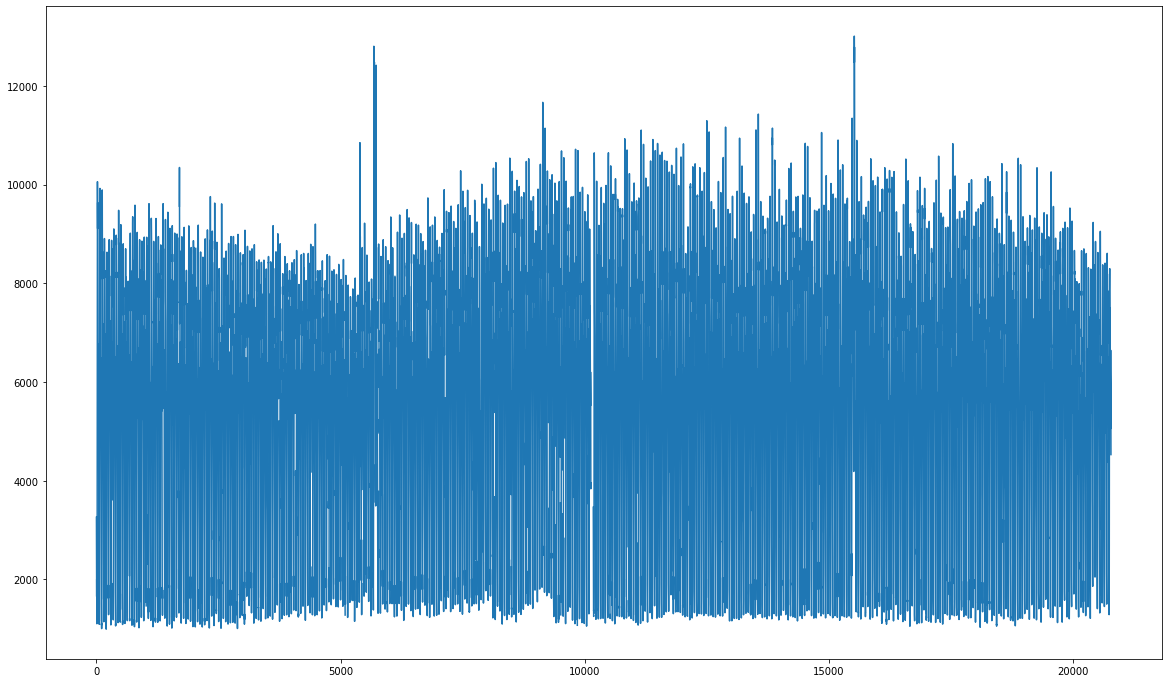

In [9]:
plt.plot(inverse_scaler(scaled_X,minX,maxX))
plt.show()

In [10]:
def partitionSet(test_fraction, data, partitions):
    lenX = len(data)
    test_size = int(len(data) * test_fraction)
    test_df = data[int((partitions/100)*lenX):int((partitions/100)*lenX)+test_size]
    train_df = ma.vstack((data[:int((partitions/100)*lenX)-1],data[int((partitions/100)*lenX)+test_size:]))
    train_df[int((partitions/100)*lenX)] = ma.masked
    return train_df, test_df

train_dataf = []
test_dataf = []

partitions=70

for i in range(1, partitions):
    [train_df,test_df] = partitionSet(0.3,scaled_X,i)
    train_dataf.append(train_df)
    test_dataf.append(test_df)

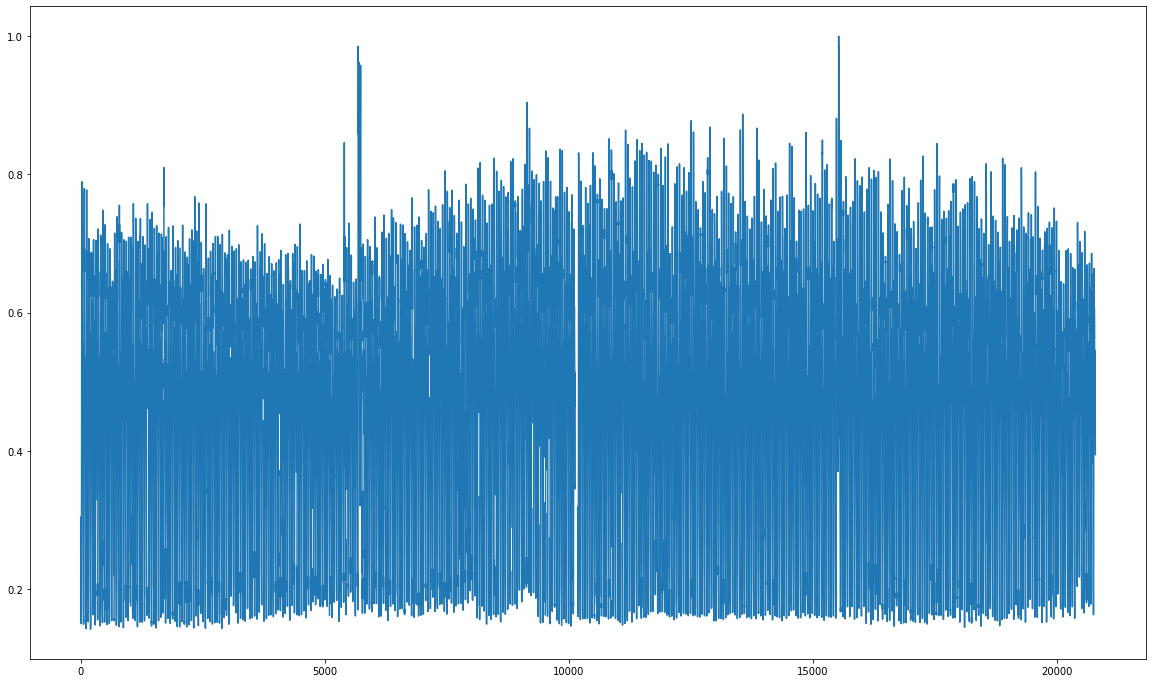

In [11]:
plt.plot(scaled_X)
plt.show()

In [12]:
def Dataset(train, test, timesteps):
    X_train = ma.array([train[t:t+timesteps] for t in range(0,len(train)-timesteps)])
    y_train = train[timesteps:, :]
    X_test = ma.array([test[t:t+timesteps] for t in range(0,len(test)-timesteps)])
    y_test = test[timesteps:, :]
    return X_train, y_train, X_test, y_test

train_X_data = []
train_Y_data = []
test_X_data = []
test_Y_data = []


for j in range(0, len(train_dataf)):
    [train_X_dates,train_Y_dates,test_X_dates,test_Y_dates]=Dataset(train_dataf[j],test_dataf[j], 24)
    train_X_data.append(train_X_dates)
    train_Y_data.append(train_Y_dates)
    test_X_data.append(test_X_dates)
    test_Y_data.append(test_Y_dates)

In [13]:
with open('train_X_data.npy', 'wb') as f:
    np.save(f, [train_X_data[i] for i in range(0, len(train_dataf))])

In [14]:
with open('train_Y_data.npy', 'wb') as f:
    np.save(f, [train_Y_data[i] for i in range(0, len(train_dataf))])

In [15]:
with open('test_X_data.npy', 'wb') as f:
    np.save(f, [test_X_data[i] for i in range(0, len(train_dataf))])

In [16]:
with open('test_Y_data.npy', 'wb') as f:
    np.save(f, [test_Y_data[i] for i in range(0, len(train_dataf))])

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

In [18]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience=6, min_delta=0.00001, mode='min')

In [19]:
def LSTM_function(NCells, timesteps, num_features, dropout, NBEpochs, Batchsize, validationSplit, earlystopping, i):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(timesteps, num_features)))
    model.add(LSTM(1, activation = 'tanh', input_shape = (timesteps, num_features), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(NCells))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss = 'mse', optimizer='adam')
    X_ = ma.filled(train_X_data[i],0)
    Y_ = ma.filled(train_Y_data[i],0)
    MODEL = model.fit(X_, Y_, epochs = NBEpochs, batch_size = Batchsize,
                      validation_split = validationSplit, shuffle = False,
                      callbacks=[earlystopping])
    return model, MODEL

In [21]:
df_train = []
df_validation = []
models = []
MODELS = []

datasets = np.arange(0, partitions-1)

for j in datasets:
    [model, MODEL] = LSTM_function(64,np.shape(train_X_data[0])[1], 1, 0.05, 200, 128, 0.2, early_stopping, j)
    df_train.append(MODEL.history['loss'])
    df_validation.append(MODEL.history['val_loss'])
    models.append(model)
    MODELS.append(MODEL)

Epoch 1/200
91/91 [==============================] - 11s 57ms/step - loss: 0.0538 - val_loss: 0.0273
Epoch 2/200
91/91 [==============================] - 3s 36ms/step - loss: 0.0290 - val_loss: 0.0181
Epoch 3/200
91/91 [==============================] - 3s 36ms/step - loss: 0.0208 - val_loss: 0.0166
Epoch 4/200
91/91 [==============================] - 3s 37ms/step - loss: 0.0171 - val_loss: 0.0122
Epoch 5/200
91/91 [==============================] - 3s 33ms/step - loss: 0.0127 - val_loss: 0.0089
Epoch 6/200
91/91 [==============================] - 3s 37ms/step - loss: 0.0096 - val_loss: 0.0065
Epoch 7/200
91/91 [==============================] - 3s 37ms/step - loss: 0.0078 - val_loss: 0.0060
Epoch 8/200
91/91 [==============================] - 3s 36ms/step - loss: 0.0072 - val_loss: 0.0055
Epoch 9/200
91/91 [==============================] - 3s 34ms/step - loss: 0.0067 - val_loss: 0.0054
Epoch 10/200
91/91 [==============================] - 3s 38ms/step - loss: 0.0062 - val_loss: 0.005

91/91 [==============================] - 3s 37ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 31/200
91/91 [==============================] - 3s 28ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 32/200
91/91 [==============================] - 2s 25ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 33/200
91/91 [==============================] - 2s 25ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 34/200
91/91 [==============================] - 2s 26ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 35/200
91/91 [==============================] - 2s 26ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 36/200
91/91 [==============================] - 2s 26ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 37/200
91/91 [==============================] - 2s 25ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 38/200
91/91 [==============================] - 2s 26ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 39/200
91/91 [==============================] - 2s 26ms/step - loss: 0.0029 - val_loss: 0.0016
Epo

91/91 [==============================] - 3s 28ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 16/200
91/91 [==============================] - 3s 28ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 17/200
91/91 [==============================] - 3s 28ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 18/200
91/91 [==============================] - 2s 27ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 19/200
91/91 [==============================] - 3s 28ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 20/200
91/91 [==============================] - 3s 28ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 21/200
91/91 [==============================] - 2s 27ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 22/200
91/91 [==============================] - 2s 26ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 23/200
91/91 [==============================] - 2s 27ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 24/200
91/91 [==============================] - 2s 26ms/step - loss: 0.0031 - val_loss: 0.0025
Epo

91/91 [==============================] - 2s 25ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 42/200
91/91 [==============================] - 2s 24ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 43/200
91/91 [==============================] - 2s 25ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 44/200
91/91 [==============================] - 2s 26ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 45/200
91/91 [==============================] - 2s 27ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 46/200
91/91 [==============================] - 2s 26ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 47/200
91/91 [==============================] - 2s 25ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 48/200
91/91 [==============================] - 2s 24ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 49/200
91/91 [==============================] - 2s 25ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 50/200
91/91 [==============================] - 2s 26ms/step - loss: 0.0031 - val_loss: 0.0016
Epo

91/91 [==============================] - 2s 26ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 83/200
91/91 [==============================] - 2s 25ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 84/200
91/91 [==============================] - 2s 25ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 85/200
91/91 [==============================] - 2s 26ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 86/200
91/91 [==============================] - 3s 28ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 87/200
91/91 [==============================] - 2s 26ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 88/200
91/91 [==============================] - 2s 26ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 89/200
91/91 [==============================] - 2s 27ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 90/200
91/91 [==============================] - 2s 28ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 91/200
91/91 [==============================] - 2s 27ms/step - loss: 0.0024 - val_loss: 0.0013
Epo

91/91 [==============================] - 2s 23ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 17/200
91/91 [==============================] - 2s 24ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 18/200
91/91 [==============================] - 2s 24ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 19/200
91/91 [==============================] - 2s 25ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 20/200
91/91 [==============================] - 2s 23ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 21/200
91/91 [==============================] - 2s 24ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 22/200
91/91 [==============================] - 2s 24ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 23/200
91/91 [==============================] - 2s 23ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 24/200
91/91 [==============================] - 2s 24ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 25/200
91/91 [==============================] - 2s 24ms/step - loss: 0.0034 - val_loss: 0.0021
Epo

91/91 [==============================] - 2s 24ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 53/200
91/91 [==============================] - 2s 24ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 54/200
91/91 [==============================] - 2s 24ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 55/200
91/91 [==============================] - 2s 24ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 56/200
91/91 [==============================] - 2s 23ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 57/200
91/91 [==============================] - 2s 23ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 58/200
91/91 [==============================] - 2s 24ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 59/200
91/91 [==============================] - 2s 24ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 60/200
91/91 [==============================] - 2s 24ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 61/200
91/91 [==============================] - 2s 24ms/step - loss: 0.0032 - val_loss: 0.0015
Epo

91/91 [==============================] - 2s 25ms/step - loss: 0.0046 - val_loss: 0.0036
Epoch 19/200
91/91 [==============================] - 2s 24ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 20/200
91/91 [==============================] - 2s 23ms/step - loss: 0.0044 - val_loss: 0.0035
Epoch 21/200
91/91 [==============================] - 2s 23ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 22/200
91/91 [==============================] - 2s 22ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 23/200
91/91 [==============================] - 2s 23ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 24/200
91/91 [==============================] - 2s 22ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 25/200
91/91 [==============================] - 2s 22ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 26/200
91/91 [==============================] - 2s 22ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 27/200
91/91 [==============================] - 2s 23ms/step - loss: 0.0039 - val_loss: 0.0030
Epo

91/91 [==============================] - 2s 22ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 46/200
91/91 [==============================] - 2s 21ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 47/200
91/91 [==============================] - 2s 22ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 48/200
91/91 [==============================] - 2s 21ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 49/200
91/91 [==============================] - 2s 22ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 50/200
91/91 [==============================] - 2s 23ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 51/200
91/91 [==============================] - 2s 21ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 52/200
91/91 [==============================] - 2s 22ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 53/200
91/91 [==============================] - 2s 22ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 54/200
91/91 [==============================] - 2s 22ms/step - loss: 0.0028 - val_loss: 0.0016
Epo

91/91 [==============================] - 2s 23ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 31/200
91/91 [==============================] - 2s 23ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 32/200
91/91 [==============================] - 2s 23ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 33/200
91/91 [==============================] - 2s 24ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 34/200
91/91 [==============================] - 2s 22ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 35/200
91/91 [==============================] - 2s 23ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 36/200
91/91 [==============================] - 2s 23ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 37/200
91/91 [==============================] - 2s 24ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 38/200
91/91 [==============================] - 2s 23ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 39/200
91/91 [==============================] - 2s 23ms/step - loss: 0.0033 - val_loss: 0.0018
Epo

91/91 [==============================] - 2s 26ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 35/200
91/91 [==============================] - 2s 26ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 36/200
91/91 [==============================] - 2s 27ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 37/200
91/91 [==============================] - 2s 26ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 38/200
91/91 [==============================] - 2s 25ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 39/200
91/91 [==============================] - 2s 25ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 40/200
91/91 [==============================] - 2s 26ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 1/200
91/91 [==============================] - 11s 42ms/step - loss: 0.0553 - val_loss: 0.0304
Epoch 2/200
91/91 [==============================] - 2s 27ms/step - loss: 0.0336 - val_loss: 0.0291
Epoch 3/200
91/91 [==============================] - 2s 25ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch

91/91 [==============================] - 2s 26ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 71/200
91/91 [==============================] - 2s 27ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 72/200
91/91 [==============================] - 3s 28ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 1/200
91/91 [==============================] - 9s 45ms/step - loss: 0.0499 - val_loss: 0.0257
Epoch 2/200
91/91 [==============================] - 3s 28ms/step - loss: 0.0206 - val_loss: 0.0147
Epoch 3/200
91/91 [==============================] - 2s 27ms/step - loss: 0.0159 - val_loss: 0.0129
Epoch 4/200
91/91 [==============================] - 2s 27ms/step - loss: 0.0138 - val_loss: 0.0101
Epoch 5/200
91/91 [==============================] - 3s 29ms/step - loss: 0.0115 - val_loss: 0.0076
Epoch 6/200
91/91 [==============================] - 3s 29ms/step - loss: 0.0084 - val_loss: 0.0052
Epoch 7/200
91/91 [==============================] - 3s 30ms/step - loss: 0.0071 - val_loss: 0.0044
Epoch 8/20

91/91 [==============================] - 3s 29ms/step - loss: 0.0042 - val_loss: 0.0023
Epoch 21/200
91/91 [==============================] - 3s 29ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 22/200
91/91 [==============================] - 3s 29ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 23/200
91/91 [==============================] - 3s 29ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 24/200
91/91 [==============================] - 3s 30ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 25/200
91/91 [==============================] - 3s 30ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 26/200
91/91 [==============================] - 3s 30ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 27/200
91/91 [==============================] - 3s 30ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 28/200
91/91 [==============================] - 3s 30ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 29/200
91/91 [==============================] - 3s 29ms/step - loss: 0.0037 - val_loss: 0.0017
Epo

91/91 [==============================] - 3s 30ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 57/200
91/91 [==============================] - 3s 34ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 58/200
91/91 [==============================] - 3s 32ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 59/200
91/91 [==============================] - 3s 32ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 60/200
91/91 [==============================] - 3s 30ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 61/200
91/91 [==============================] - 3s 30ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 62/200
91/91 [==============================] - 3s 30ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 63/200
91/91 [==============================] - 3s 31ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 64/200
91/91 [==============================] - 3s 29ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 65/200
91/91 [==============================] - 3s 31ms/step - loss: 0.0032 - val_loss: 0.0012
Epo

91/91 [==============================] - 3s 32ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 62/200
91/91 [==============================] - 3s 35ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 63/200
91/91 [==============================] - 3s 34ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 64/200
91/91 [==============================] - 3s 33ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 65/200
91/91 [==============================] - 3s 35ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 66/200
91/91 [==============================] - 3s 33ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 67/200
91/91 [==============================] - 3s 32ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 68/200
91/91 [==============================] - 3s 33ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 69/200
91/91 [==============================] - 3s 34ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 70/200
91/91 [==============================] - 3s 34ms/step - loss: 0.0032 - val_loss: 0.0014
Epo

91/91 [==============================] - 3s 32ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 41/200
91/91 [==============================] - 3s 33ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 42/200
91/91 [==============================] - 3s 33ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 43/200
91/91 [==============================] - 3s 33ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 44/200
91/91 [==============================] - 3s 32ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 45/200
91/91 [==============================] - 3s 35ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 46/200
91/91 [==============================] - 3s 36ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 47/200
91/91 [==============================] - 3s 35ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 48/200
91/91 [==============================] - 3s 36ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 49/200
91/91 [==============================] - 3s 36ms/step - loss: 0.0037 - val_loss: 0.0017
Epo

91/91 [==============================] - 3s 38ms/step - loss: 0.0044 - val_loss: 0.0026
Epoch 19/200
91/91 [==============================] - 4s 39ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 20/200
91/91 [==============================] - 4s 40ms/step - loss: 0.0043 - val_loss: 0.0023
Epoch 21/200
91/91 [==============================] - 3s 37ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 22/200
91/91 [==============================] - 3s 38ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 23/200
91/91 [==============================] - 3s 39ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 24/200
91/91 [==============================] - 3s 37ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 25/200
91/91 [==============================] - 3s 38ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 26/200
91/91 [==============================] - 3s 38ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 27/200
91/91 [==============================] - 3s 38ms/step - loss: 0.0040 - val_loss: 0.0017
Epo

91/91 [==============================] - 4s 40ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 45/200
91/91 [==============================] - 4s 43ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 46/200
91/91 [==============================] - 4s 42ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 47/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 48/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 49/200
91/91 [==============================] - 4s 42ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 50/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 51/200
91/91 [==============================] - 4s 39ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 52/200
91/91 [==============================] - 3s 39ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 53/200
91/91 [==============================] - 3s 38ms/step - loss: 0.0043 - val_loss: 0.0021
Epo

91/91 [==============================] - 4s 42ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 33/200
91/91 [==============================] - 4s 42ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 34/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0047 - val_loss: 0.0025
Epoch 35/200
91/91 [==============================] - 4s 42ms/step - loss: 0.0047 - val_loss: 0.0024
Epoch 36/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 37/200
91/91 [==============================] - 4s 42ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 38/200
91/91 [==============================] - 4s 42ms/step - loss: 0.0045 - val_loss: 0.0023
Epoch 39/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 40/200
91/91 [==============================] - 4s 42ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 41/200
91/91 [==============================] - 4s 42ms/step - loss: 0.0045 - val_loss: 0.0022
Epo

91/91 [==============================] - 4s 43ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 36/200
91/91 [==============================] - 4s 43ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 37/200
91/91 [==============================] - 4s 43ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 38/200
91/91 [==============================] - 4s 42ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 39/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 40/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 41/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 1/200
91/91 [==============================] - 10s 56ms/step - loss: 0.0466 - val_loss: 0.0322
Epoch 2/200
91/91 [==============================] - 4s 39ms/step - loss: 0.0358 - val_loss: 0.0314
Epoch 3/200
91/91 [==============================] - 4s 43ms/step - loss: 0.0340 - val_loss: 0.0275
Epoch

91/91 [==============================] - 4s 42ms/step - loss: 0.0061 - val_loss: 0.0040
Epoch 15/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0058 - val_loss: 0.0039
Epoch 16/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0058 - val_loss: 0.0037
Epoch 17/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0056 - val_loss: 0.0036
Epoch 18/200
91/91 [==============================] - 4s 42ms/step - loss: 0.0056 - val_loss: 0.0036
Epoch 19/200
91/91 [==============================] - 4s 42ms/step - loss: 0.0055 - val_loss: 0.0034
Epoch 20/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0052 - val_loss: 0.0035
Epoch 21/200
91/91 [==============================] - 4s 43ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 22/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 23/200
91/91 [==============================] - 4s 42ms/step - loss: 0.0051 - val_loss: 0.0033
Epo

91/91 [==============================] - 4s 43ms/step - loss: 0.0039 - val_loss: 0.0016
Epoch 54/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 55/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 56/200
91/91 [==============================] - 4s 42ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 57/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 58/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 59/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 60/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 61/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 62/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0038 - val_loss: 0.0016
Epo

91/91 [==============================] - 4s 41ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 38/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 39/200
91/91 [==============================] - 4s 40ms/step - loss: 0.0044 - val_loss: 0.0021
Epoch 40/200
91/91 [==============================] - 4s 40ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 41/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 42/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 43/200
91/91 [==============================] - 4s 42ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 44/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 45/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 46/200
91/91 [==============================] - 4s 41ms/step - loss: 0.0041 - val_loss: 0.0020
Epo

In [22]:
for i in datasets:
    models[i].save('/home/costa/Institute/ModelsForAlicante/Benalua/models/BenaluaModel'+str(i)+'.h5')

In [ ]:
for i in datasets:
    MODELS[i].save('/home/costa/Institute/ModelsForAlicante/Benalua/MODELS/BenaluaModel'+str(i)+'.h5')

In [23]:
train_performance = []
for i in datasets:
    train_performance.append(np.array(df_train[i]))

In [24]:
val_performance = []
for i in datasets:
    val_performance.append(np.array(df_validation[i]))

In [25]:
with open('train_performance.npy', 'wb') as f:
    np.save(f, [train_performance[i] for i in datasets])

In [26]:
with open('val_performance.npy', 'wb') as f:
    np.save(f, [val_performance[i] for i in datasets])

In [1]:
import re #python regular expression matching module
script = re.sub(r'# In\[.*\]:\n','',open('3.0-Model.py').read())
with open('3.0-ModelScript.py','w') as fh:
    fh.write(script)